# KFL annual report probability visualisation
This notebook loads the KFL annual report BERT outputs, combines them with a year column, and plots trends of how often each label is predicted strongly across multiple thresholds. Place the yearly CSVs in `KFLdata/` before running.


In [1]:
# One-time install of plotting libraries (uncomment if needed)
%pip install -q matplotlib seaborn



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_colwidth", 120)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 10)

CODE_PREFIX = "KFL"

data_dir = Path("KFLdata")
csv_paths = sorted(data_dir.glob(f"preds-KFL*.csv"))
page_counts_path = Path("outputs/page_counts.csv")

csv_paths


[PosixPath('KFLdata/preds-KFL2010.csv'),
 PosixPath('KFLdata/preds-KFL2011.csv'),
 PosixPath('KFLdata/preds-KFL2012.csv'),
 PosixPath('KFLdata/preds-KFL2013.csv'),
 PosixPath('KFLdata/preds-KFL2014.csv'),
 PosixPath('KFLdata/preds-KFL2015.csv'),
 PosixPath('KFLdata/preds-KFL2016.csv'),
 PosixPath('KFLdata/preds-KFL2017.csv'),
 PosixPath('KFLdata/preds-KFL2018.csv'),
 PosixPath('KFLdata/preds-KFL2019.csv'),
 PosixPath('KFLdata/preds-KFL2020.csv'),
 PosixPath('KFLdata/preds-KFL2021.csv')]

In [3]:
# Load all yearly CSVs and attach a year column from the filename
def load_yearly(paths):
    if not paths:
        raise FileNotFoundError(f"No CSVs found for pattern preds-{CODE_PREFIX}*.csv in {data_dir}")
    frames = []
    for path in paths:
        year = int(path.stem.replace(f"preds-{CODE_PREFIX}", ""))
        df = pd.read_csv(path)
        df["year"] = year
        df["word_count"] = df["sentence"].fillna("").str.split().str.len()
        frames.append(df)
    return pd.concat(frames, ignore_index=True)


def load_page_counts(path):
    if not path.exists():
        return pd.DataFrame(columns=["year", "page_count"])
    page_counts = pd.read_csv(path)
    required_cols = {"code_year", "pages"}
    missing_cols = required_cols - set(page_counts.columns)
    if missing_cols:
        raise ValueError(f"Missing columns in page counts file: {missing_cols}")
    page_counts = page_counts[page_counts["code_year"].astype(str).str.startswith(CODE_PREFIX)]
    if page_counts.empty:
        return pd.DataFrame(columns=["year", "page_count"])
    page_counts["year"] = page_counts["code_year"].str.extract(r"(\d{4})").astype(int)
    page_counts = page_counts[["year", "pages"]].rename(columns={"pages": "page_count"})
    return page_counts

# Run scripts/page_counts.py to generate outputs/page_counts.csv from PDFs in reports/
page_counts = load_page_counts(page_counts_path)

df = load_yearly(csv_paths)
df.head()


,sentence,source_page,source_pdf,prob_fin_label,prob_soc_label,prob_env_label,prob_maori_label,year,word_count
0,Kingfish Limited Annual Report 31 March 2010,1,KFL2010,0.051781,0.000494,0.989118,0.002019,2010,7
1,2 kingfish limited annual report 2010 2010/2011 calendar Dividend Payable 18 June 2010 June Quarter Update newslette...,2,KFL2010,0.005768,0.005605,0.984602,0.004946,2010,95
2,About the Company. . . . . . . . . . . . . . . . . . . . . . . . . . .,2,KFL2010,0.041914,0.513835,0.407756,0.086877,2010,29
3,Directors’ Report. . . . . . . . . . . . . . . . . . . . . . . . . . . .,2,KFL2010,0.027305,0.345530,0.619653,0.099302,2010,29
4,Manager’s Report. . . . . . . . . . . . . . . . . . . . . . . . . . . .,2,KFL2010,0.025435,0.406827,0.531381,0.094302,2010,29


In [4]:
# Quick data health check
prob_cols = ["prob_fin_label", "prob_soc_label", "prob_env_label", "prob_maori_label"]
display(df[["year"] + prob_cols].describe(include="all"))


,year,prob_fin_label,prob_soc_label,prob_env_label,prob_maori_label
count,8039.000000,8039.000000,8039.000000,8039.000000,8039.000000
mean,2015.832193,0.552808,0.258529,0.192107,0.003521
std,3.432146,0.461909,0.404749,0.357897,0.029636
min,2010.000000,0.000512,0.000112,0.000060,0.000055
25%,2013.000000,0.010978,0.001863,0.002387,0.000883
50%,2016.000000,0.833870,0.004745,0.005206,0.001660
75%,2019.000000,0.998367,0.512719,0.084033,0.002831
max,2021.000000,0.999642,0.999066,0.999390,0.998536


In [5]:
# Reshape to long format for easier analysis across labels
long_df = df.melt(
    id_vars=["year", "word_count"],
    value_vars=prob_cols,
    var_name="label",
    value_name="probability"
)
long_df["label"] = long_df["label"].str.replace("prob_", "").str.replace("_label", "").str.upper()
long_df.head()


,year,word_count,label,probability
0,2010,7,FIN,0.051781
1,2010,95,FIN,0.005768
2,2010,29,FIN,0.041914
3,2010,29,FIN,0.027305
4,2010,29,FIN,0.025435


In [6]:
# Helpers to summarize and plot strong predictions at arbitrary thresholds
BASE_YEAR = 2018

def summarize_over_threshold(df_long, threshold):
    over_mask = df_long["probability"] > threshold
    enriched = df_long.assign(
        over=over_mask,
        over_word_count=lambda d: d["word_count"].where(over_mask, 0)
    )

    agg = (
        enriched
        .groupby(["year", "label"])
        .agg(
            total_sentences=("probability", "size"),
            total_words=("word_count", "sum"),
            over_count=("over", "sum"),
            over_share=("over", "mean"),  # same as count/total sentences
            over_word_count=("over_word_count", "sum"),
            mean_prob_over=("probability", lambda s: s[s > threshold].mean() if (s > threshold).any() else 0.0),
            sum_prob_over=("probability", lambda s: s[s > threshold].sum()),
        )
        .reset_index()
    )
    agg = agg.merge(page_counts, on="year", how="left")
    agg["page_count"] = agg["page_count"].replace({0: pd.NA})
    agg["over_sentence_word_share"] = agg["over_count"] / agg["total_words"]
    agg["over_word_share"] = agg["over_word_count"] / agg["total_words"]
    agg["sentences_per_page"] = agg["total_sentences"] / agg["page_count"]
    agg["over_sentences_per_page"] = agg["over_count"] / agg["page_count"]
    agg["over_words_per_page"] = agg["over_word_count"] / agg["page_count"]
    agg["theme_rate_per_1000_words"] = np.where(
        agg["total_words"] > 0,
        (agg["over_count"] / agg["total_words"]) * 1000,
        0.0,
    )
    non_theme = agg["total_sentences"] - agg["over_count"]
    agg["theme_ratio_per_1000_sentences"] = np.where(
        non_theme > 0,
        (agg["over_count"] / non_theme) * 1000,
        0.0,
    )
    base_counts = agg["label"].map(
        agg.loc[agg["year"] == BASE_YEAR, ["label", "over_count"]]
        .drop_duplicates(subset=["label"])
        .set_index("label")["over_count"]
    )
    agg["theme_index_base"] = np.where(
        base_counts > 0,
        (agg["over_count"] / base_counts) * 100,
        0.0,
    )
    agg["avg_theme_score_relevant"] = agg["mean_prob_over"]
    agg["threshold"] = threshold
    return agg


thresholds = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
summaries = {thr: summarize_over_threshold(long_df, thr) for thr in thresholds}

# Quick peek at the first threshold summary
preview_threshold = thresholds[0]
summaries[preview_threshold].head()


,year,label,total_sentences,total_words,over_count,over_share,over_word_count,mean_prob_over,sum_prob_over,page_count,over_sentence_word_share,over_word_share,sentences_per_page,over_sentences_per_page,over_words_per_page,theme_rate_per_1000_words,theme_ratio_per_1000_sentences,theme_index_base,avg_theme_score_relevant,threshold
0,2010,ENV,544,13600,81,0.148897,2154,0.947959,76.784665,48,0.005956,0.158382,11.333333,1.687500,44.875000,5.955882,174.946004,88.043478,0.947959,0.7
1,2010,FIN,544,13600,296,0.544118,7783,0.975827,288.844837,48,0.021765,0.572279,11.333333,6.166667,162.145833,21.764706,1193.548387,83.146067,0.975827,0.7
2,2010,MAORI,544,13600,0,0.000000,0,0.000000,0.000000,48,0.000000,0.000000,11.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.7
3,2010,SOC,544,13600,121,0.222426,2564,0.966981,117.004717,48,0.008897,0.188529,11.333333,2.520833,53.416667,8.897059,286.052009,76.100629,0.966981,0.7
4,2011,ENV,559,13928,86,0.153846,2139,0.932014,80.153227,52,0.006175,0.153576,10.750000,1.653846,41.134615,6.174612,181.818182,93.478261,0.932014,0.7


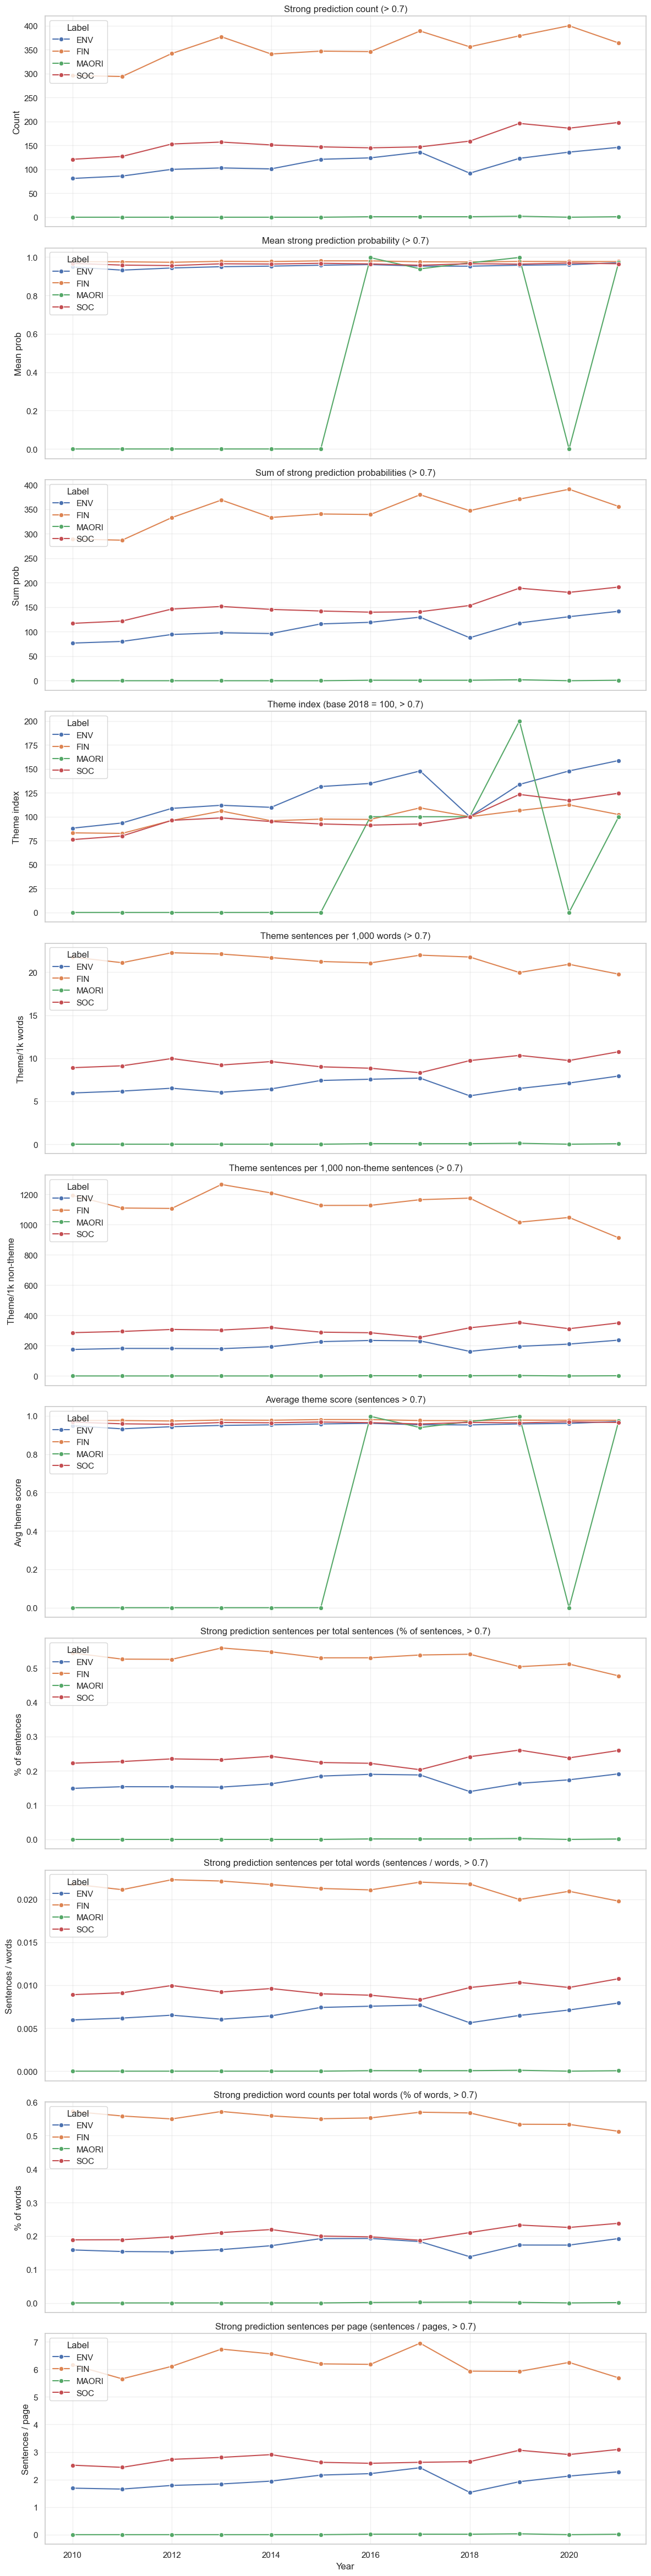

In [7]:
# Combined view for threshold > 0.7 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.7)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.7)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.7)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.7)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.7)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.7)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.7)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.7)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.7)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.7)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.7)"),
]
summary = summaries[0.7]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


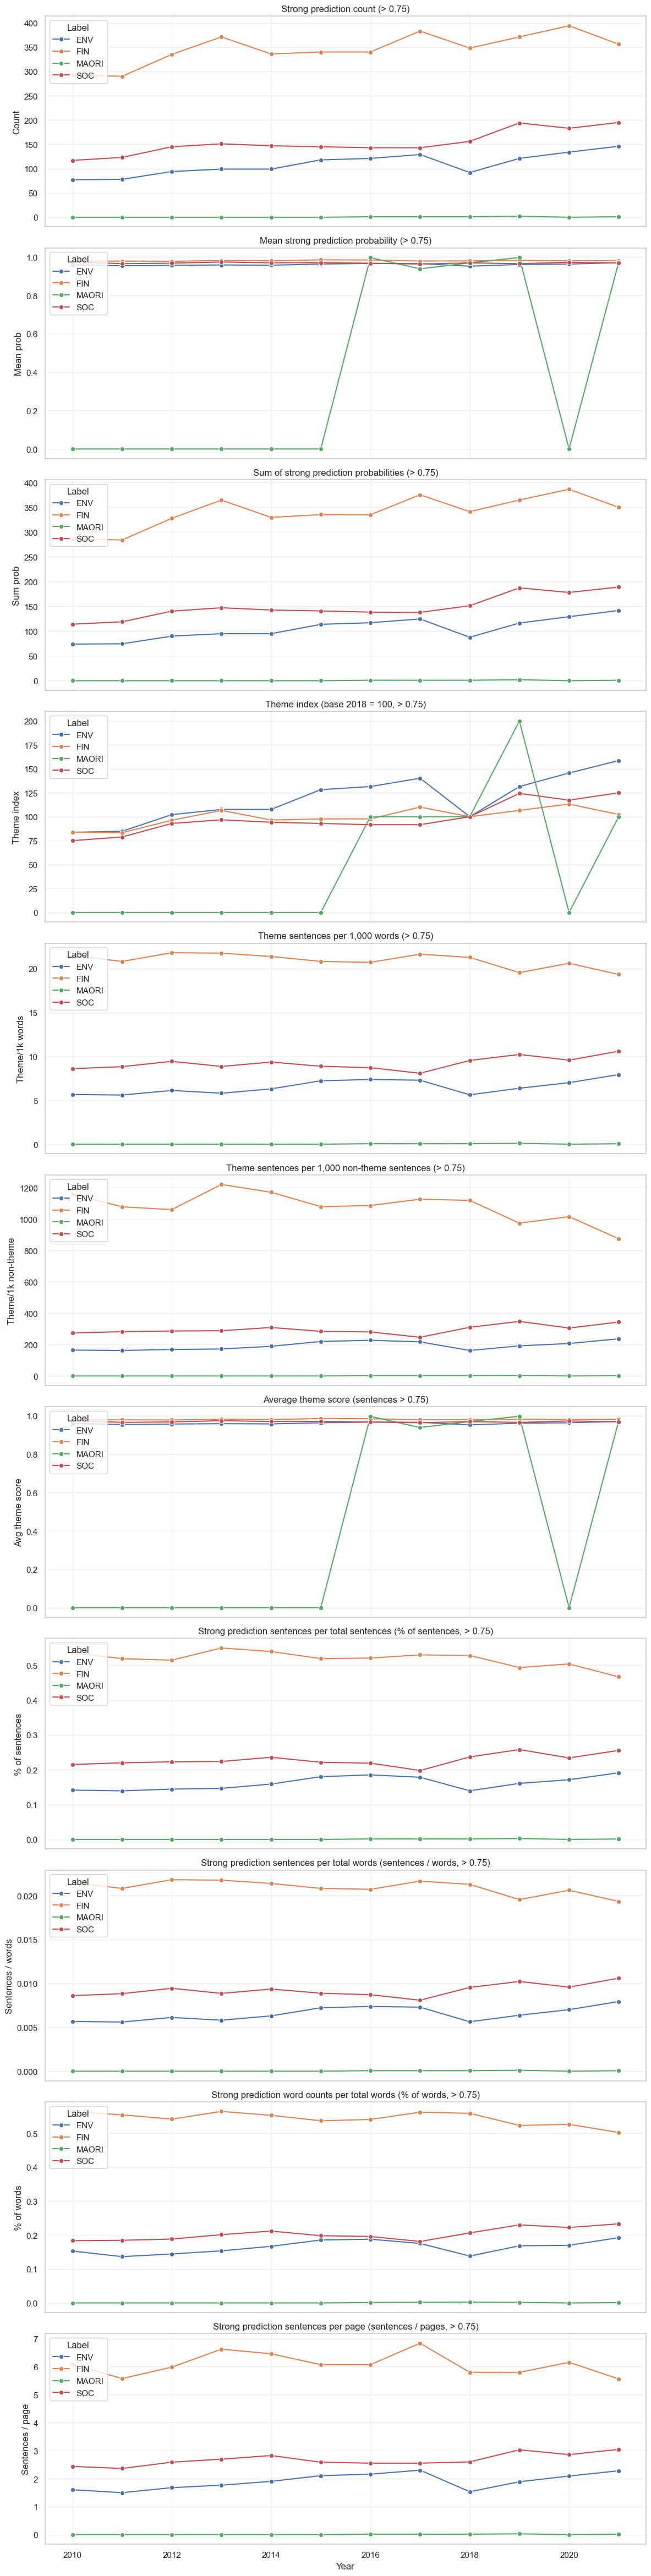

In [8]:
# Combined view for threshold > 0.75 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.75)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.75)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.75)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.75)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.75)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.75)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.75)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.75)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.75)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.75)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.75)"),
]
summary = summaries[0.75]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


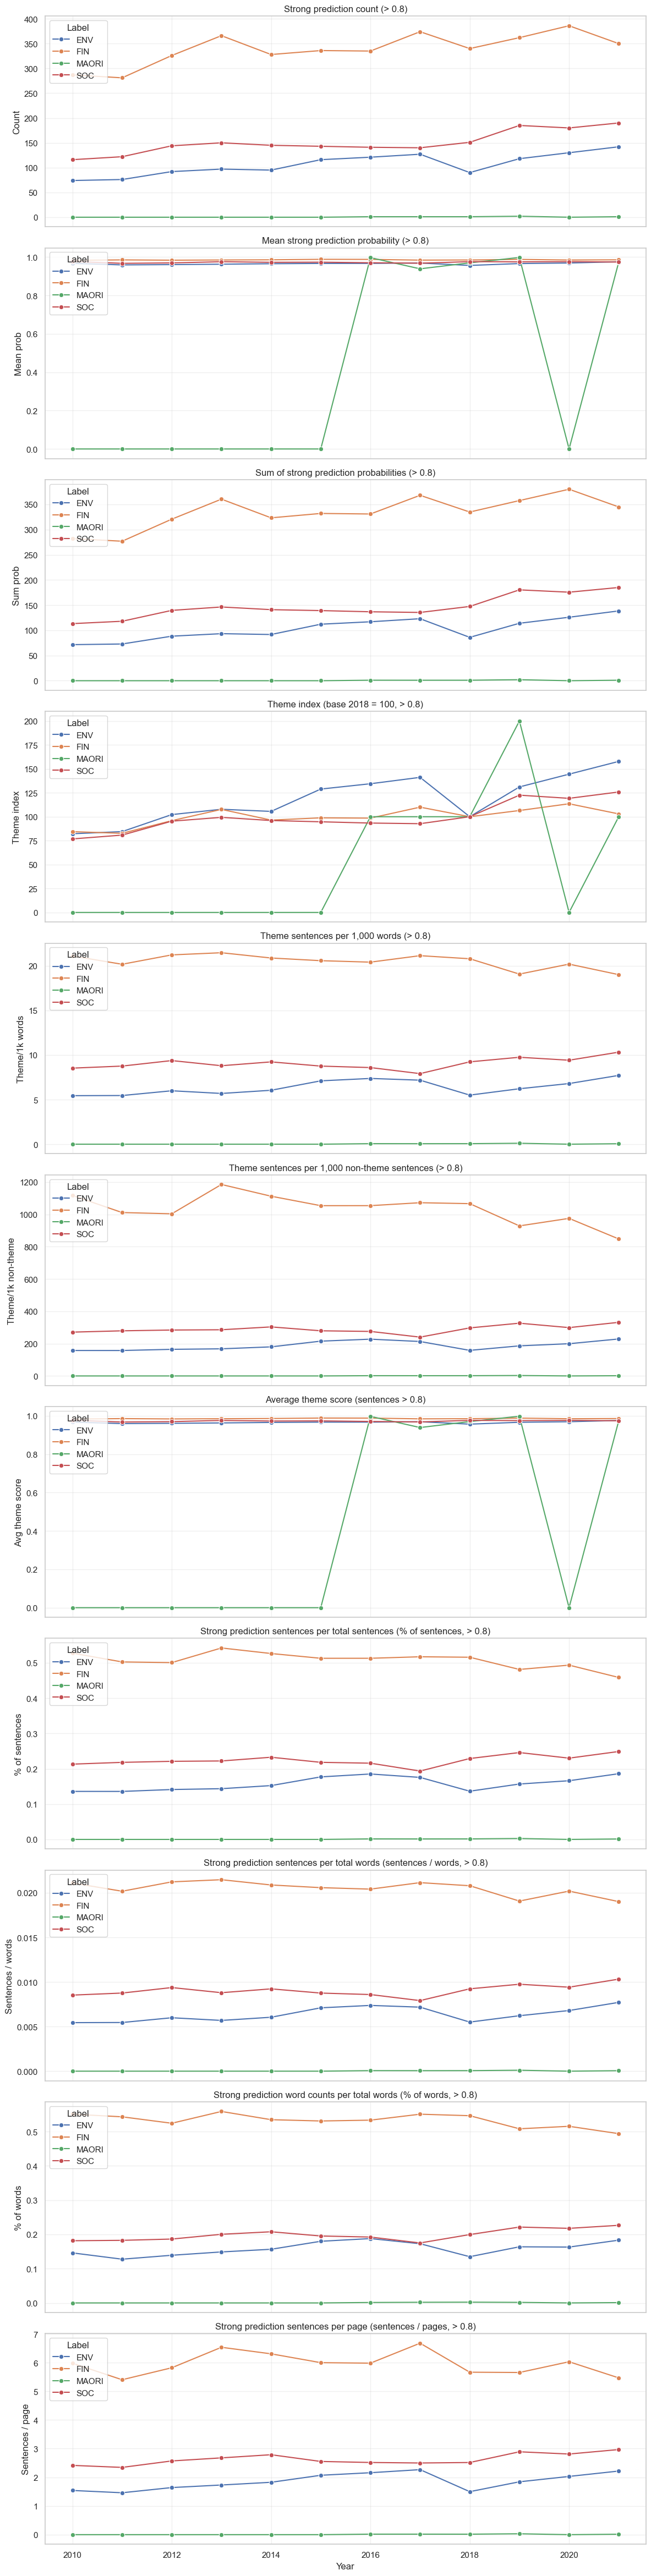

In [9]:
# Combined view for threshold > 0.8 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.8)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.8)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.8)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.8)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.8)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.8)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.8)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.8)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.8)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.8)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.8)"),
]
summary = summaries[0.8]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


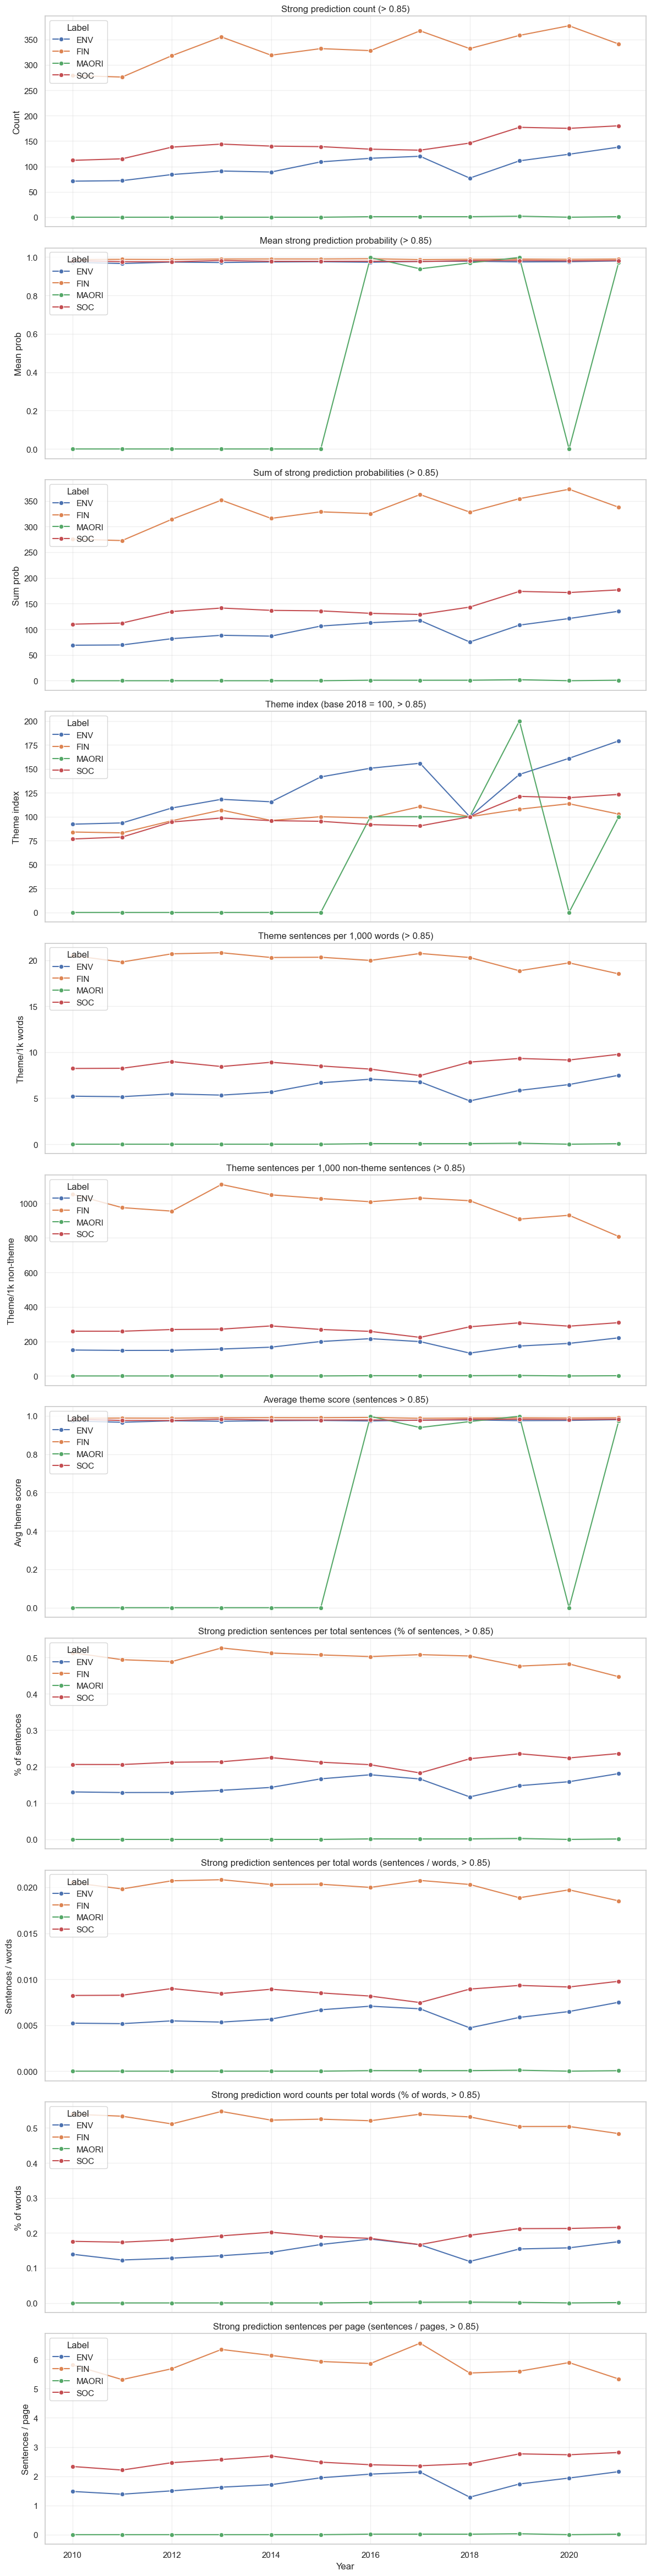

In [10]:
# Combined view for threshold > 0.85 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.85)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.85)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.85)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.85)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.85)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.85)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.85)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.85)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.85)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.85)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.85)"),
]
summary = summaries[0.85]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


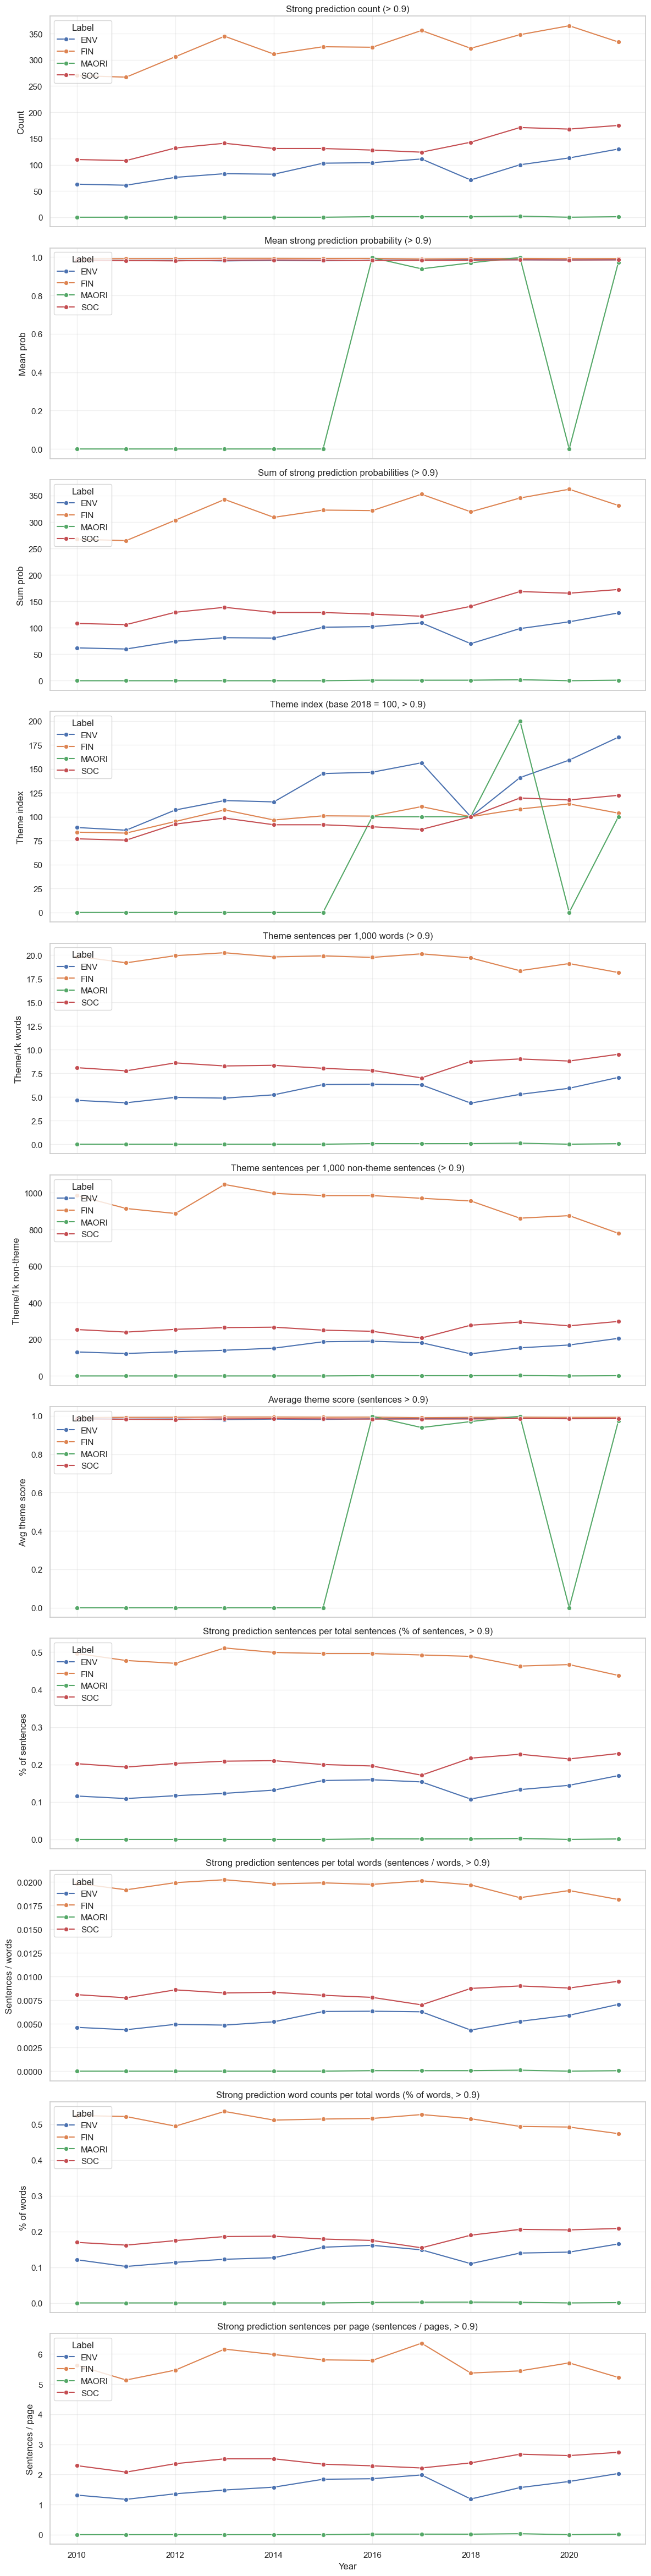

In [11]:
# Combined view for threshold > 0.9 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.9)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.9)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.9)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.9)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.9)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.9)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.9)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.9)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.9)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.9)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.9)"),
]
summary = summaries[0.9]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


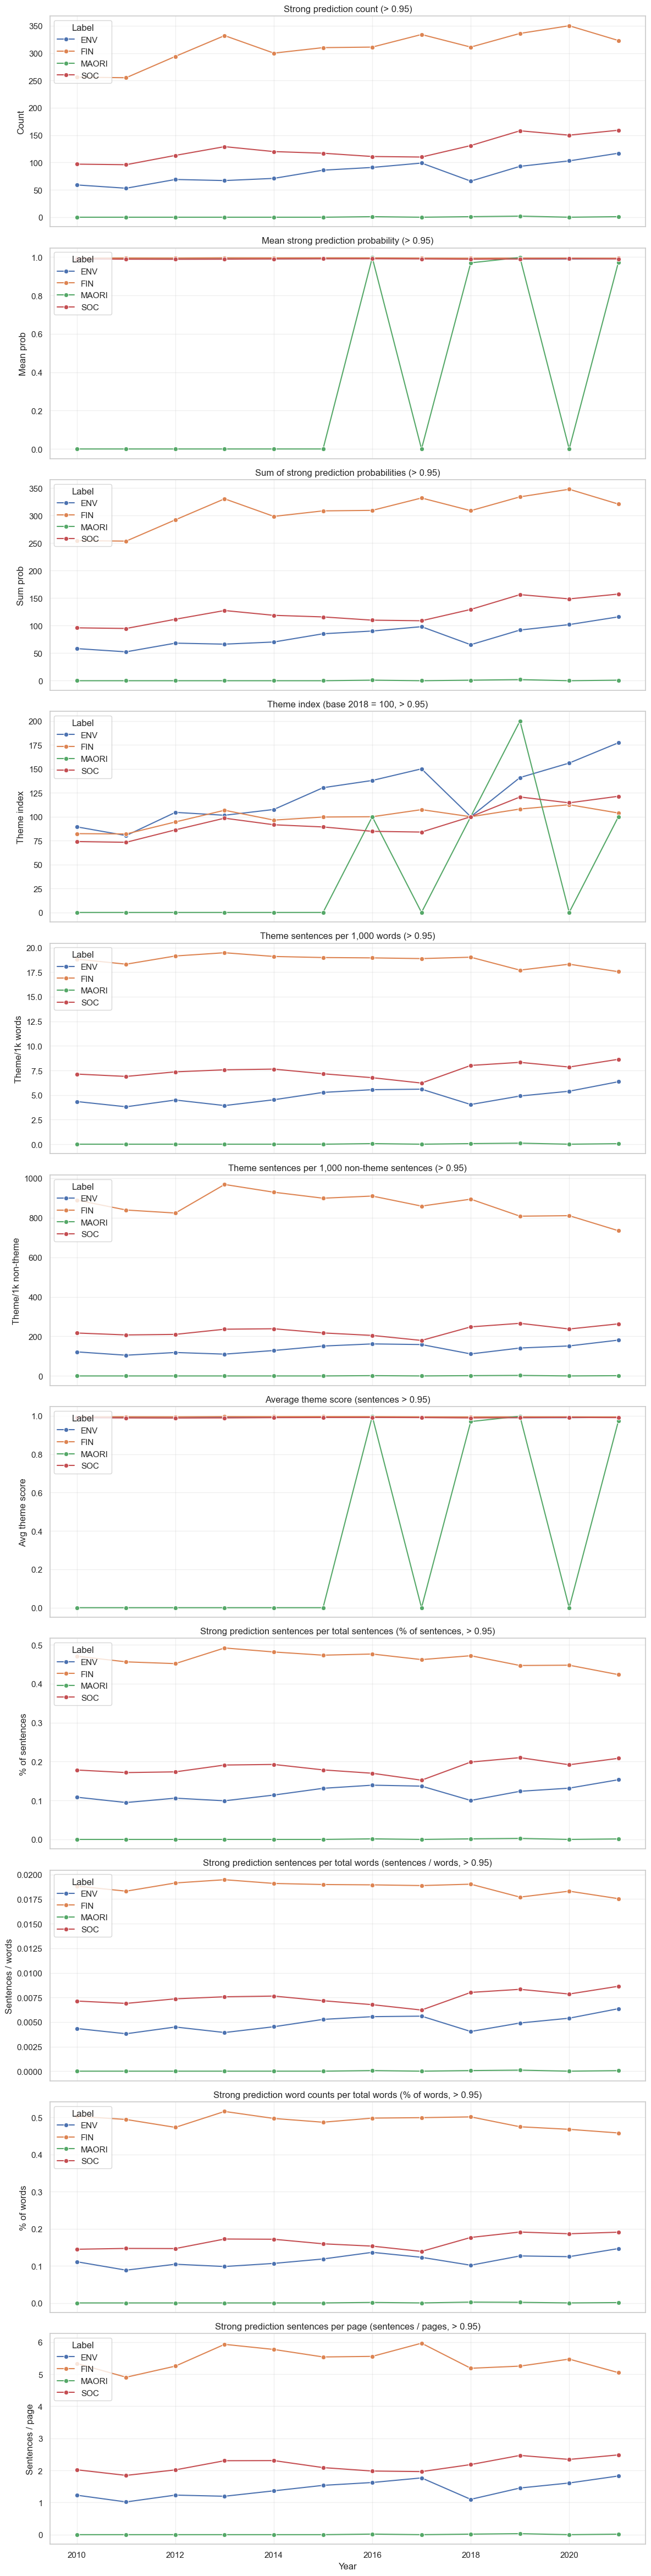

In [12]:
# Combined view for threshold > 0.95 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.95)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.95)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.95)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.95)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.95)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.95)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.95)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.95)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.95)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.95)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.95)"),
]
summary = summaries[0.95]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


Notes
- over_count: how many sentences per label per year with predicted probability above the chosen threshold.
- over_share: same as over_count / total sentences for that year+label (proportion of strong predictions).
- over_sentence_word_share: strong prediction sentences divided by total words in that year+label grouping.
- over_word_share: total words from strong prediction sentences divided by total words for that year+label grouping.
- over_sentences_per_page: strong prediction sentences divided by page count for that year (requires page_counts.csv).
- over_words_per_page: total words from strong prediction sentences divided by page count for that year (requires page_counts.csv).
- mean_prob_over: average probability for those sentences above the threshold (NaN if none above threshold).
